In [9]:
import pandas as pd
%matplotlib inline
from aws_helpers import execute_athena_query
import matplotlib.pyplot as plt

results_url = execute_athena_query("select site_id, site_name, lat, lon, avg(temperature) as temperature from weather group by site_id, site_name, lat, lon")
df = pd.read_csv(results_url)

df

Executing: select site_id, site_name, lat, lon, avg(temperature) as temperature from weather group by site_id, site_name, lat, lon
Wait count 0/30
Wait count 1/30
Query succeeded


,site_id,site_name,lat,lon,temperature
0,3031,LOCH GLASCARNOCH,57.7250,-4.8960,4.829082
1,3047,TULLOCH BRIDGE,56.8670,-4.7080,4.688500
2,3080,ABOYNE,57.0770,-2.8360,4.225126
3,3088,INVERBERVIE,56.8520,-2.2640,5.430653
4,3238,ALBEMARLE,55.0200,-1.8800,5.058291
...,...,...,...,...,...
132,3862,BOURNEMOUTH AIRPORT,50.7790,-1.8350,10.331325
133,3907,MAGILLIGAN,55.1604,-6.9492,6.454315
134,3911,LOUGH FEA,54.7210,-6.8140,5.719474
135,3916,BALLYPATRICK FOREST,55.1810,-6.1530,6.832000


# Raw Scatter plot

Note that the latitude will look very compressed, because the earth is round ;)

<AxesSubplot:xlabel='lon', ylabel='lat'>

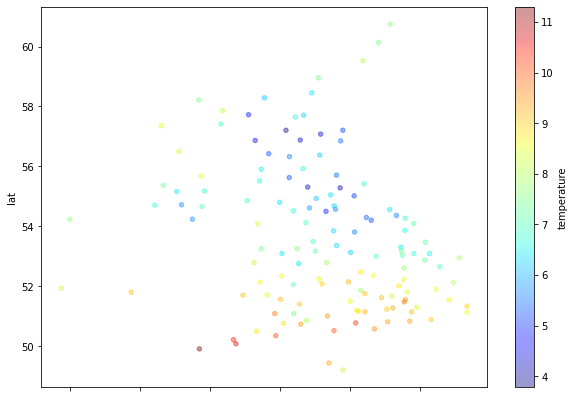

In [10]:
df.plot(
    kind="scatter",
    x="lon", y="lat",
    figsize=(10,7),
    cmap=plt.get_cmap("jet"),
    c='temperature',
    colorbar=True, alpha=0.4
)

# ipyleaflet

Looks amazing, but doesn't work in PyCharm :(

```python
from ipyleaflet import *
from ipywidgets import Layout

m = Map(center=(55, -1), zoom=8, basemap=basemaps.OpenStreetMap.Mapnik)

m.layout.width = '50%'
m.layout.height = '300px'

m
```

In [21]:
import folium
from branca.element import Figure

fig=Figure(width=600,height=600)

m = folium.Map(location=[51.5, -1], tiles = 'Stamen Terrain')
fig.add_child(m)

m